<a href="https://colab.research.google.com/github/OshiMC/DrawingRecognition_For_DS_Children_ML_Model/blob/main/DrawingRecognition_For_DS_Children.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Dec  9 05:12:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)



2.19.0


In [ ]:
!pip install scikit-learn
!pip install opencv-python
!pip install matplotlib
!pip install pandas
!pip install pillow
!pip install tensorflow_decision_forests
!pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.3/390.3 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for tflite-support: filename=tflite_support-0.1.0a1-cp312-cp312-linux_x86_64.whl size=6042498 sha256=5565229f16ab216740b2bfe9db05df6996eb0ee11b624b406f690ca751bef1e9
  Stored in directory: /root/.cache/pip/wheels/5d/6f/bc/8b85ad0e51d3c8f82c590b321f2c5b35c41fbe84ad93271397
Successfully built tflite-support


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")



TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
IMAGE_SIZE = (224, 224)

train_path = '/content/drive/MyDrive/Dataset/Training Data'
valid_path = '/content/drive/MyDrive/Dataset/Testing Data'




In [ ]:
import os

def explore_dataset(train_path, valid_path):
    """Explore and understand your dataset structure"""
    print("=" * 50)
    print("DATASET EXPLORATION")
    print("=" * 50)

    # Training data
    train_classes = os.listdir(train_path)
    print(f"\n📁 Training Data Path: {train_path}")
    print(f"Number of classes: {len(train_classes)}")
    print(f"Classes: {train_classes}\n")

    for class_name in train_classes:
        class_path = os.path.join(train_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"  ├── {class_name}: {num_images} images")

    # Validation data
    print(f"\n📁 Validation Data Path: {valid_path}")
    valid_classes = os.listdir(valid_path)
    print(f"Number of classes: {len(valid_classes)}")
    print(f"Classes: {valid_classes}\n")

    for class_name in valid_classes:
        class_path = os.path.join(valid_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"  ├── {class_name}: {num_images} images")

    print("\n" + "=" * 50)
    # Run exploration
explore_dataset(train_path, valid_path)

DATASET EXPLORATION

📁 Training Data Path: /content/drive/MyDrive/Dataset/Training Data
Number of classes: 26
Classes: ['y.letter y', 'z.letter z', 'x.letter X', 'w.watch', 'u.umbrella', 'v.vehicle', 't.triangle', 's.star', 'q.letter Q', 'r.rectangle', 'p.pencil', 'o.number One', 'n.net', 'm.mango', 'k.kite', 'j.jug', 'i.ice cream', 'l.leaf', 'g.glass', 'h.house', 'f.flower', 'e.eye', 'd.door', 'c.circle', 'a.apple', 'b.bag']

  ├── y.letter y: 120 images
  ├── z.letter z: 120 images
  ├── x.letter X: 120 images
  ├── w.watch: 120 images
  ├── u.umbrella: 120 images
  ├── v.vehicle: 120 images
  ├── t.triangle: 120 images
  ├── s.star: 120 images
  ├── q.letter Q: 120 images
  ├── r.rectangle: 120 images
  ├── p.pencil: 120 images
  ├── o.number One: 120 images
  ├── n.net: 120 images
  ├── m.mango: 120 images
  ├── k.kite: 120 images
  ├── j.jug: 120 images
  ├── i.ice cream: 120 images
  ├── l.leaf: 120 images
  ├── g.glass: 120 images
  ├── h.house: 120 images
  ├── f.flower: 120 im

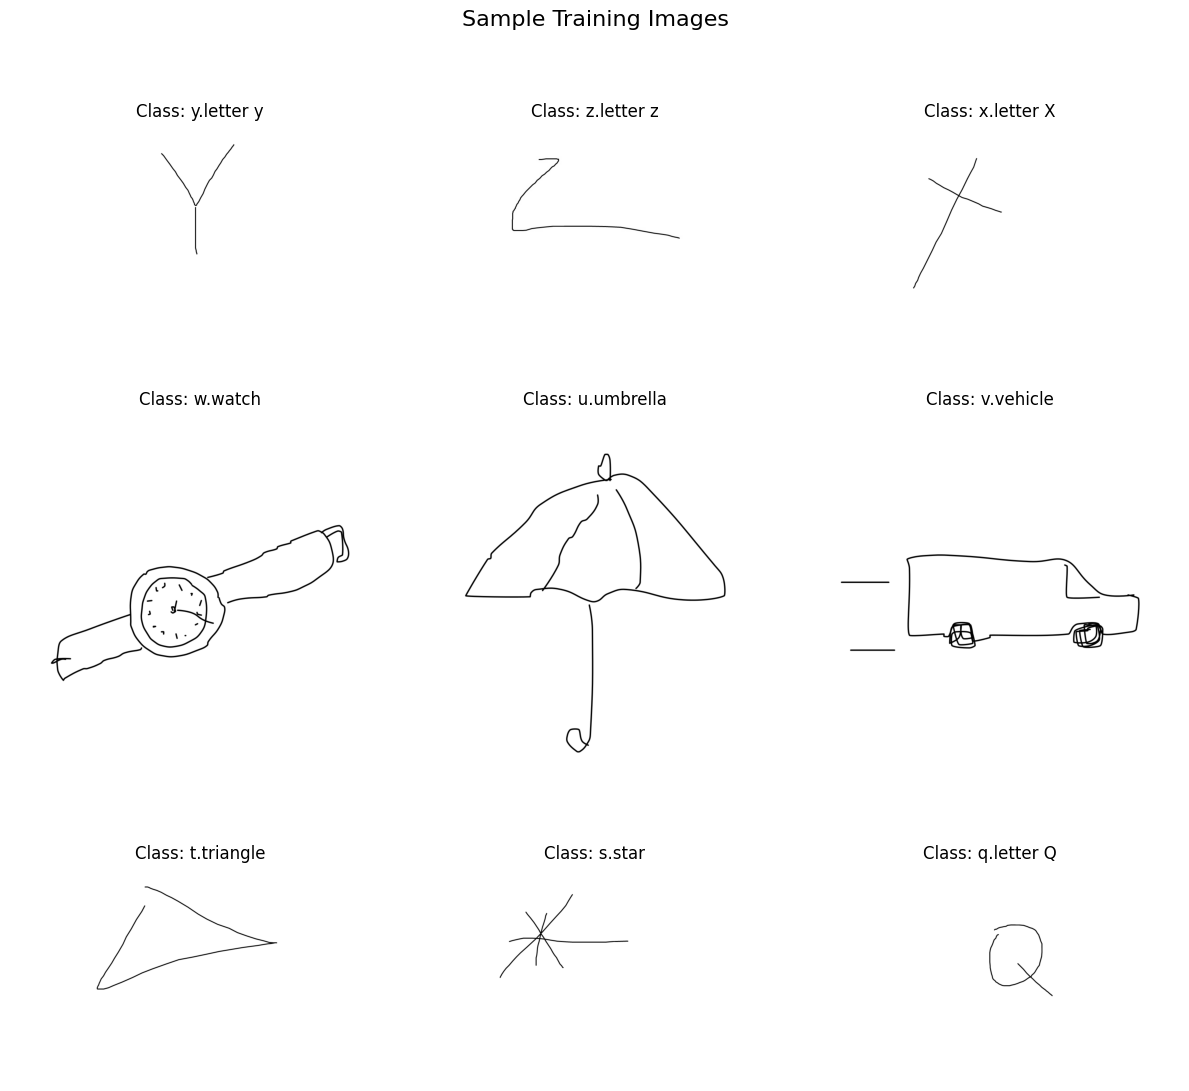

In [ ]:
def visualize_samples(data_path, num_samples=9):
    """Visualize sample images from dataset"""
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Sample Training Images', fontsize=16)

    for idx, ax in enumerate(axes.flat):
        if idx < len(classes):
            class_name = classes[idx]
            class_path = os.path.join(data_path, class_name)
            images = os.listdir(class_path)

            if images:
                img_path = os.path.join(class_path, images[0])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
                ax.set_title(f'Class: {class_name}')
                ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_samples(train_path)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import missing libraries
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [ ]:
IMG_HEIGHT, IMG_WIDTH = IMAGE_SIZE
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

print("\n📊 Training Configuration:")
print(f"  Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")



📊 Training Configuration:
  Image Size: 224x224
  Batch Size: 32
  Epochs: 50
  Learning Rate: 0.001


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data (only rescaling, no augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Display dataset info
num_classes = len(train_generator.class_indices)
print(f"\n✓ Data generators created successfully!")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")
print(f"  Number of classes: {num_classes}")
print(f"  Class indices: {train_generator.class_indices}")

Found 3120 images belonging to 26 classes.
Found 520 images belonging to 26 classes.

✓ Data generators created successfully!
  Training samples: 3120
  Validation samples: 520
  Number of classes: 26
  Class indices: {'a.apple': 0, 'b.bag': 1, 'c.circle': 2, 'd.door': 3, 'e.eye': 4, 'f.flower': 5, 'g.glass': 6, 'h.house': 7, 'i.ice cream': 8, 'j.jug': 9, 'k.kite': 10, 'l.leaf': 11, 'm.mango': 12, 'n.net': 13, 'o.number One': 14, 'p.pencil': 15, 'q.letter Q': 16, 'r.rectangle': 17, 's.star': 18, 't.triangle': 19, 'u.umbrella': 20, 'v.vehicle': 21, 'w.watch': 22, 'x.letter X': 23, 'y.letter y': 24, 'z.letter z': 25}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("✓ ImageDataGenerator imported successfully!")

✓ ImageDataGenerator imported successfully!


In [ ]:
#  Build the CNN Model
# ============================================
def build_drawing_cnn(num_classes, img_height, img_width):
    """
    Custom CNN architecture optimized for children's drawing recognition
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create model
model = build_drawing_cnn(num_classes, IMG_HEIGHT, IMG_WIDTH)

# Display model summary
print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,007,802 (103.03 MB)

 Trainable params: 27,004,346 (103.01 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
from tensorflow.keras import layers, models

print("✓ Keras models and layers imported!")

✓ Keras models and layers imported!


In [ ]:
#Compile the Model
# ============================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print("\n✓ Model compiled successfully!")



✓ Model compiled successfully!


In [ ]:
# ============================================
# ALL IMPORTS FOR CHROMABLOOM - RUN THIS FIRST!
# ============================================

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

print("="*60)
print("✓ ALL IMPORTS SUCCESSFUL!")
print(f"✓ TensorFlow: {tf.__version__}")
print(f"✓ GPU: {len(tf.config.list_physical_devices('GPU'))} device(s)")
print("="*60)

✓ ALL IMPORTS SUCCESSFUL!
✓ TensorFlow: 2.19.0
✓ GPU: 1 device(s)


In [ ]:
# STEP 7: Setup Callbacks
# ============================================
# Create directory for saving models
MODEL_SAVE_PATH = '/content/drive/MyDrive/ChromaBloom_Models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Checkpoint callback - saves best model
checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_SAVE_PATH, 'best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.3f}.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping - prevents overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Custom callback to log progress
class TrainingLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\n📈 Epoch {epoch + 1} Summary:")
        print(f"  Train Acc: {logs['accuracy']:.4f} | Val Acc: {logs['val_accuracy']:.4f}")
        print(f"  Train Loss: {logs['loss']:.4f} | Val Loss: {logs['val_loss']:.4f}")

callbacks = [checkpoint, early_stopping, reduce_lr, TrainingLogger()]

print("\n✓ Callbacks configured!")


✓ Callbacks configured!


In [ ]:
# STEP 8: Train the Model
# ============================================
print("\n" + "="*50)
print("STARTING MODEL TRAINING")
print("="*50)
print("This may take a while... Grab a coffee ☕")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")


STARTING MODEL TRAINING
This may take a while... Grab a coffee ☕


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.0616 - loss: 4.4743 - precision: 0.0626 - recall: 0.0119 - top_3_accuracy: 0.1516 
Epoch 1: val_accuracy improved from -inf to 0.03846, saving model to /content/drive/MyDrive/ChromaBloom_Models/best_model_epoch_01_val_acc_0.038.h5



📈 Epoch 1 Summary:
  Train Acc: 0.0654 | Val Acc: 0.0385
  Train Loss: 4.3183 | Val Loss: 3.6205
17/17 ━━━━━━━━━━━━━━━━━━━━ 2936s 180s/step - accuracy: 0.0618 - loss: 4.4657 - precision: 0.0641 - recall: 0.0122 - top_3_accuracy: 0.1529 - val_accuracy: 0.0385 - val_loss: 3.6205 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_3_accuracy: 0.1154 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.0659 - loss: 3.7621 - precision: 0.0253 - recall: 0.0051 - top_3_accuracy: 0.2472
Epoch 2: val_accuracy did not improve from 0.03846

📈 Epoch 2 Summary:
  Train Acc: 0.0885 | Val Acc: 0.0385
  Train Loss: 3.7366 | Val Loss: 4.3045
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0672 - loss: 3.7607 - precision: 0.0286 - recall: 0.0058 - top_3_accuracy: 0.2484 - val_accuracy: 0.0385 - val_loss: 4.3045 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_3_accuracy: 0.1154 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Check  data paths are correct
print("Checking data paths...")
print(f"Train path exists: {os.path.exists(train_path)}")
print(f"Valid path exists: {os.path.exists(valid_path)}")
print(f"\nTrain path contents: {os.listdir(train_path)}")
print(f"Valid path contents: {os.listdir(valid_path)}")

# Check number of classes and samples
print(f"\nNumber of classes: {len(train_generator.class_indices)}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Checking data paths...
Train path exists: True
Valid path exists: True

Train path contents: ['z.letter z', 'y.letter y', 'w.watch', 't.triangle', 'v.vehicle', 'u.umbrella', 's.star', 'x.letter X', 'r.rectangle', 'q.letter Q', 'p.pencil', 'n.net', 'o.number One', 'l.leaf', 'k.kite', 'm.mango', 'j.jug', 'g.glass', 'i.ice cream', 'h.house', 'f.flower', 'e.eye', 'd.door', 'c.circle', 'b.bag', 'a.apple']
Valid path contents: ['y.letter y', 'z.letter z', 'x.letter X', 'w.watch', 'u.umbrella', 'v.vehicle', 't.triangle', 's.star', 'q.letter Q', 'r.rectangle', 'p.pencil', 'o.number One', 'n.net', 'm.mango', 'k.kite', 'j.jug', 'i.ice cream', 'l.leaf', 'g.glass', 'h.house', 'f.flower', 'e.eye', 'd.door', 'c.circle', 'a.apple', 'b.bag']

Number of classes: 26
Training samples: 520
Validation samples: 3120


In [ ]:
# check  data distribution
print("="*60)
print("DIAGNOSING TRAINING ISSUES")
print("="*60)

DIAGNOSING TRAINING ISSUES


In [ ]:
# Check class distribution
print("\n1️⃣ CLASS DISTRIBUTION:")
print(f"Training classes: {train_generator.class_indices}")
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Samples per class:")
for class_name, class_idx in train_generator.class_indices.items():
    train_count = np.sum(train_generator.classes == class_idx)
    val_count = np.sum(validation_generator.classes == class_idx)
    print(f"  {class_name}: Train={train_count}, Val={val_count}")



1️⃣ CLASS DISTRIBUTION:
Training classes: {'a.apple': 0, 'b.bag': 1, 'c.circle': 2, 'd.door': 3, 'e.eye': 4, 'f.flower': 5, 'g.glass': 6, 'h.house': 7, 'i.ice cream': 8, 'j.jug': 9, 'k.kite': 10, 'l.leaf': 11, 'm.mango': 12, 'n.net': 13, 'o.number One': 14, 'p.pencil': 15, 'q.letter Q': 16, 'r.rectangle': 17, 's.star': 18, 't.triangle': 19, 'u.umbrella': 20, 'v.vehicle': 21, 'w.watch': 22, 'x.letter X': 23, 'y.letter y': 24, 'z.letter z': 25}
Number of training samples: 520
Number of validation samples: 3120
Samples per class:
  a.apple: Train=20, Val=120
  b.bag: Train=20, Val=120
  c.circle: Train=20, Val=120
  d.door: Train=20, Val=120
  e.eye: Train=20, Val=120
  f.flower: Train=20, Val=120
  g.glass: Train=20, Val=120
  h.house: Train=20, Val=120
  i.ice cream: Train=20, Val=120
  j.jug: Train=20, Val=120
  k.kite: Train=20, Val=120
  l.leaf: Train=20, Val=120
  m.mango: Train=20, Val=120
  n.net: Train=20, Val=120
  o.number One: Train=20, Val=120
  p.pencil: Train=20, Val=120
 

In [ ]:
#FIX 1: SIMPLIFIED MODEL ARCHITECTURE
# ============================================
print("\n2️⃣ BUILDING SIMPLIFIED MODEL...")

def build_improved_cnn(num_classes):
    """
    Lighter model with better regularization
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create new model
model = build_improved_cnn(num_classes)
model.summary()


2️⃣ BUILDING SIMPLIFIED MODEL...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,792,218 (98.39 MB)

 Trainable params: 25,791,258 (98.39 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# FIX 2: BETTER OPTIMIZER AND LEARNING RATE
# ============================================
print("\n3️⃣ CONFIGURING OPTIMIZER...")

# Use lower learning rate and better optimizer
initial_learning_rate = 0.0001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✓ Initial learning rate: {initial_learning_rate}")



3️⃣ CONFIGURING OPTIMIZER...
✓ Initial learning rate: 0.0001


In [ ]:
# FIX 3: IMPROVED DATA AUGMENTATION
# ============================================
print("\n4️⃣ RECREATING DATA GENERATORS...")

# Less aggressive augmentation
train_datagen_fixed = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen_fixed = ImageDataGenerator(rescale=1./255)

# Recreate generators
train_generator_fixed = train_datagen_fixed.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,  # Smaller batch size
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator_fixed = valid_datagen_fixed.flow_from_directory(
    valid_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f"✓ Batch size reduced to 16")
print(f"✓ Training samples: {train_generator_fixed.samples}")
print(f"✓ Validation samples: {validation_generator_fixed.samples}")


4️⃣ RECREATING DATA GENERATORS...
Found 3120 images belonging to 26 classes.
Found 520 images belonging to 26 classes.
✓ Batch size reduced to 16
✓ Training samples: 3120
✓ Validation samples: 520


In [ ]:
# FIX 4: BETTER CALLBACKS
# ============================================
print("\n5️⃣ SETTING UP CALLBACKS...")

# More patient early stopping
checkpoint_fixed = ModelCheckpoint(
    filepath=os.path.join(MODEL_SAVE_PATH, 'best_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_fixed = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience
    restore_best_weights=True,
    verbose=1
)

# More aggressive learning rate reduction
reduce_lr_fixed = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks_fixed = [checkpoint_fixed, early_stopping_fixed, reduce_lr_fixed]



5️⃣ SETTING UP CALLBACKS...


In [ ]:
# FIX 5: TRAIN WITH MONITORING
# ============================================
print("\n" + "="*60)
print("STARTING IMPROVED TRAINING")
print("="*60)

EPOCHS_FIXED = 100

history = model.fit(
    train_generator_fixed,
    epochs=EPOCHS_FIXED,
    validation_data=validation_generator_fixed,
    callbacks=callbacks_fixed,
    verbose=1
)



STARTING IMPROVED TRAINING


ValueError: You must call `compile()` before using the model.

In [ ]:
# Run this diagnostic first
print("Dataset Check:")
print(f"Total training samples: {train_generator_fixed.samples}")
print(f"Total validation samples: {validation_generator_fixed.samples}")
print(f"Number of classes: {len(train_generator_fixed.class_indices)}")

# Calculate average per class
avg_per_class = train_generator_fixed.samples / len(train_generator_fixed.class_indices)
print(f"\nAverage samples per class: {avg_per_class:.0f}")

if avg_per_class < 20:
    print("\n⚠️ WARNING: Very small dataset!")
    print("   - Model may not train well")
    print("   - Consider collecting more data")
    print("   - Or reduce number of classes")

Dataset Check:
Total training samples: 3120
Total validation samples: 520
Number of classes: 26

Average samples per class: 120


In [ ]:
print("="*60)
print("TRANSFER LEARNING APPROACH")
print("="*60)

TRANSFER LEARNING APPROACH


In [ ]:
# Use your existing generator
num_classes = len(train_generator_fixed.class_indices)

model_transfer = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

print("\n✓ Transfer learning model created")
print(f"✓ Number of classes: {num_classes}")

# Compile
model_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

# Setup callbacks
checkpoint_transfer = ModelCheckpoint(
    filepath=os.path.join(MODEL_SAVE_PATH, 'transfer_best_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_transfer = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_transfer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks_transfer = [checkpoint_transfer, early_stopping_transfer, reduce_lr_transfer]

# Train Phase 1
print("\n" + "="*60)
print("PHASE 1: TRAINING WITH FROZEN BASE")
print("="*60)

history_phase1 = model_transfer.fit(
    train_generator_fixed,
    epochs=30,
    validation_data=validation_generator_fixed,
    callbacks=callbacks_transfer,
    verbose=1
)

print("\n✓ Phase 1 complete!")

# Evaluate
val_loss_p1, val_acc_p1 = model_transfer.evaluate(validation_generator_fixed, verbose=0)
print(f"\nPhase 1 Results:")
print(f"  Validation Accuracy: {val_acc_p1*100:.2f}%")
print(f"  Validation Loss: {val_loss_p1:.4f}")

NameError: name 'base_model' is not defined

PHASE 01 COMPLETE
Phase 1 :

Use a pre-trained backbone ( MobileNetV2 )

Keep the backbone frozen

Train only the top classifier layers

TRANSFER LEARNING WITH MOBILENETV2

1️⃣ Loading pre-trained model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ MobileNetV2 loaded (154 layers)

2️⃣ Building model...
✓ Model created for 26 classes

3️⃣ Compiling...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,628,314 (10.03 MB)

 Trainable params: 367,258 (1.40 MB)

 Non-trainable params: 2,261,056 (8.63 MB)


4️⃣ Setting up callbacks...

PHASE 1: TRAINING (FROZEN BASE)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2880 - loss: 2.6219
Epoch 1: val_accuracy improved from -inf to 0.62885, saving model to /content/drive/MyDrive/ChromaBloom_Models/transfer_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1089s 5s/step - accuracy: 0.2888 - loss: 2.6187 - val_accuracy: 0.6288 - val_loss: 1.2860 - learning_rate: 0.0010
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6649 - loss: 1.1662
Epoch 2: val_accuracy improved from 0.62885 to 0.68654, saving model to /content/drive/MyDrive/ChromaBloom_Models/transfer_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 310ms/step - accuracy: 0.6649 - loss: 1.1661 - val_accuracy: 0.6865 - val_loss: 1.0470 - learning_rate: 0.0010
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.7248 - loss: 0.9577
Epoch 3: val_accuracy improved from 0.68654 to 0.69231, saving model to /content/drive/MyDrive/ChromaBloom_Models/transfer_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 313ms/step - accuracy: 0.7248 - loss: 0.9577 - val_accuracy: 0.6923 - val_loss: 0.9927 - learning_rate: 0.0010
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7442 - loss: 0.8809
Epoch 4: val_accuracy improved from 0.69231 to 0.72692, saving model to /content/drive/MyDrive/ChromaBloom_Models/transfer_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 310ms/step - accuracy: 0.7442 - loss: 0.8808 - val_accuracy: 0.7269 - val_loss: 0.9041 - learning_rate: 0.0010
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7629 - loss: 0.8131
Epoch 5: val_accuracy did not improve from 0.72692
195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 308ms/step - accuracy: 0.7629 - loss: 0.8129 - val_accuracy: 0.7212 - val_loss: 1.0004 - learning_rate: 0.0010
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7841 - loss: 0.7405
Epoch 6: val_accuracy did not improve from 0.72692
195/195 ━━━━━━━━━━━━━━━━━━━━ 59s 302ms/step - accuracy: 0.7840 - loss: 0.7406 - val_accuracy: 0.7154 - val_loss: 0.9885 - learning_rate: 0.0010
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7710 - loss: 0.7618
Epoch 7: val_accuracy improved from 0.72692 to 0.75769, saving model to /content/drive/MyDrive/ChromaBloom_Models/transfer_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 310ms/step - accuracy: 0.7710 - loss: 0.7617 - val_accuracy: 0.7577 - val_loss: 0.8532 - learning_rate: 0.0010
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8086 - loss: 0.6426
Epoch 8: val_accuracy did not improve from 0.75769
195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 306ms/step - accuracy: 0.8086 - loss: 0.6427 - val_accuracy: 0.7462 - val_loss: 0.8957 - learning_rate: 0.0010
Epoch 9/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8072 - loss: 0.6377
Epoch 9: val_accuracy did not improve from 0.75769
195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 309ms/step - accuracy: 0.8071 - loss: 0.6378 - val_accuracy: 0.7385 - val_loss: 0.9839 - learning_rate: 0.0010
Epoch 10/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8292 - loss: 0.5954
Epoch 10: val_accuracy did not improve from 0.75769
195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 309ms/step - accuracy: 0.8291 - loss: 0.5956 - val_accuracy: 0.7538 - val_loss: 0.9646 - learning_rate: 0.0010
Epoch


Epoch 17: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 308ms/step - accuracy: 0.8583 - loss: 0.4702 - val_accuracy: 0.7635 - val_loss: 0.9727 - learning_rate: 2.0000e-04
Epoch 18/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8455 - loss: 0.4927
Epoch 18: val_accuracy did not improve from 0.76346
195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 308ms/step - accuracy: 0.8455 - loss: 0.4927 - val_accuracy: 0.7596 - val_loss: 0.9769 - learning_rate: 4.0000e-05
Epoch 19/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8522 - loss: 0.4527
Epoch 19: val_accuracy did not improve from 0.76346
195/195 ━━━━━━━━━━━━━━━━━━━━ 59s 302ms/step - accuracy: 0.8522 - loss: 0.4528 - val_accuracy: 0.7596 - val_loss: 0.9699 - learning_rate: 4.0000e-05
Epoch 20/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8616 - loss: 0.4634
Epoch 20: val_accuracy did not improve from 0.76346
195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 311ms/step - accuracy

195/195 ━━━━━━━━━━━━━━━━━━━━ 94s 359ms/step - accuracy: 0.5887 - loss: 1.5407 - val_accuracy: 0.4731 - val_loss: 2.5774 - learning_rate: 1.0000e-04
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7426 - loss: 0.8204
Epoch 2: val_accuracy improved from 0.47308 to 0.65385, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7427 - loss: 0.8202 - val_accuracy: 0.6538 - val_loss: 1.3718 - learning_rate: 1.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7892 - loss: 0.7313
Epoch 3: val_accuracy did not improve from 0.65385
195/195 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.7892 - loss: 0.7311 - val_accuracy: 0.6500 - val_loss: 1.4983 - learning_rate: 1.0000e-04
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8150 - loss: 0.5970
Epoch 4: val_accuracy improved from 0.65385 to 0.72308, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.8151 - loss: 0.5969 - val_accuracy: 0.7231 - val_loss: 1.1480 - learning_rate: 1.0000e-04
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8441 - loss: 0.5247
Epoch 5: val_accuracy improved from 0.72308 to 0.73654, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.8441 - loss: 0.5247 - val_accuracy: 0.7365 - val_loss: 1.1416 - learning_rate: 1.0000e-04
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8534 - loss: 0.4925
Epoch 6: val_accuracy improved from 0.73654 to 0.76154, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.8534 - loss: 0.4925 - val_accuracy: 0.7615 - val_loss: 1.0905 - learning_rate: 1.0000e-04
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8527 - loss: 0.4929
Epoch 7: val_accuracy improved from 0.76154 to 0.76538, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.8527 - loss: 0.4927 - val_accuracy: 0.7654 - val_loss: 0.9006 - learning_rate: 1.0000e-04
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8716 - loss: 0.4209
Epoch 8: val_accuracy did not improve from 0.76538
195/195 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.8716 - loss: 0.4210 - val_accuracy: 0.7231 - val_loss: 1.1318 - learning_rate: 1.0000e-04
Epoch 9/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8851 - loss: 0.3943
Epoch 9: val_accuracy did not improve from 0.76538
195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 313ms/step - accuracy: 0.8852 - loss: 0.3942 - val_accuracy: 0.7385 - val_loss: 1.1245 - learning_rate: 1.0000e-04
Epoch 10/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8811 - loss: 0.3805
Epoch 10: val_accuracy improved from 0.76538 to 0.80962, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 63s 320ms/step - accuracy: 0.8811 - loss: 0.3804 - val_accuracy: 0.8096 - val_loss: 0.7239 - learning_rate: 1.0000e-04
Epoch 11/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8909 - loss: 0.3537
Epoch 11: val_accuracy improved from 0.80962 to 0.81923, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.8909 - loss: 0.3536 - val_accuracy: 0.8192 - val_loss: 0.7471 - learning_rate: 1.0000e-04
Epoch 12/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9119 - loss: 0.3009
Epoch 12: val_accuracy did not improve from 0.81923
195/195 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.9118 - loss: 0.3010 - val_accuracy: 0.8192 - val_loss: 0.7745 - learning_rate: 1.0000e-04
Epoch 13/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9184 - loss: 0.2706
Epoch 13: val_accuracy improved from 0.81923 to 0.83654, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.9184 - loss: 0.2706 - val_accuracy: 0.8365 - val_loss: 0.6955 - learning_rate: 1.0000e-04
Epoch 14/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9082 - loss: 0.2927
Epoch 14: val_accuracy did not improve from 0.83654
195/195 ━━━━━━━━━━━━━━━━━━━━ 64s 327ms/step - accuracy: 0.9082 - loss: 0.2927 - val_accuracy: 0.8096 - val_loss: 0.7672 - learning_rate: 1.0000e-04
Epoch 15/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9279 - loss: 0.2394
Epoch 15: val_accuracy did not improve from 0.83654
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 317ms/step - accuracy: 0.9279 - loss: 0.2395 - val_accuracy: 0.8288 - val_loss: 0.6743 - learning_rate: 1.0000e-04
Epoch 16/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9326 - loss: 0.2254
Epoch 16: val_accuracy did not improve from 0.83654
195/195 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.9326 - loss: 0.2255 - val_accuracy: 0.7904 - val_loss: 0.9479 - learning_ra

195/195 ━━━━━━━━━━━━━━━━━━━━ 84s 322ms/step - accuracy: 0.9225 - loss: 0.2516 - val_accuracy: 0.8481 - val_loss: 0.6707 - learning_rate: 1.0000e-04
Epoch 20/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9430 - loss: 0.1959
Epoch 20: val_accuracy improved from 0.84808 to 0.85769, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.9430 - loss: 0.1959 - val_accuracy: 0.8577 - val_loss: 0.6989 - learning_rate: 1.0000e-04
Epoch 21/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9425 - loss: 0.1827
Epoch 21: val_accuracy did not improve from 0.85769
195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 310ms/step - accuracy: 0.9424 - loss: 0.1828 - val_accuracy: 0.8538 - val_loss: 0.7095 - learning_rate: 1.0000e-04
Epoch 22/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9581 - loss: 0.1542
Epoch 22: val_accuracy did not improve from 0.85769
195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.9580 - loss: 0.1543 - val_accuracy: 0.8385 - val_loss: 0.8255 - learning_rate: 1.0000e-04
Epoch 23/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9494 - loss: 0.1889
Epoch 23: val_accuracy did not improve from 0.85769
195/195 ━━━━━━━━━━━━━━━━━━━━ 60s 309ms/step - accuracy: 0.9494 - loss: 0.1889 - val_accuracy: 0.8327 - val_loss: 0.7675 - learning_ra


Epoch 24: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
195/195 ━━━━━━━━━━━━━━━━━━━━ 84s 323ms/step - accuracy: 0.9447 - loss: 0.1818 - val_accuracy: 0.8596 - val_loss: 0.7382 - learning_rate: 1.0000e-04
Epoch 25/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9619 - loss: 0.1119
Epoch 25: val_accuracy improved from 0.85962 to 0.87500, saving model to /content/drive/MyDrive/ChromaBloom_Models/finetuned_best.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.9619 - loss: 0.1120 - val_accuracy: 0.8750 - val_loss: 0.6773 - learning_rate: 2.0000e-05
Epoch 26/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9668 - loss: 0.1229
Epoch 26: val_accuracy did not improve from 0.87500
195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 312ms/step - accuracy: 0.9667 - loss: 0.1230 - val_accuracy: 0.8577 - val_loss: 0.7066 - learning_rate: 2.0000e-05
Epoch 27/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9685 - loss: 0.1235
Epoch 27: val_accuracy did not improve from 0.87500
195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 314ms/step - accuracy: 0.9685 - loss: 0.1235 - val_accuracy: 0.8654 - val_loss: 0.6530 - learning_rate: 2.0000e-05
Epoch 28/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9608 - loss: 0.1335
Epoch 28: val_accuracy did not improve from 0.87500
195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 311ms/step - accuracy: 0.9609 - loss: 0.1334 - val_accuracy: 0.8712 - val_loss: 0.6063 - learning_ra


📊 FINAL PERFORMANCE:
   Training Accuracy: 99.74%
   Validation Accuracy: 86.73%
   Training Loss: 0.0081
   Validation Loss: 0.5855

✓ Model saved!


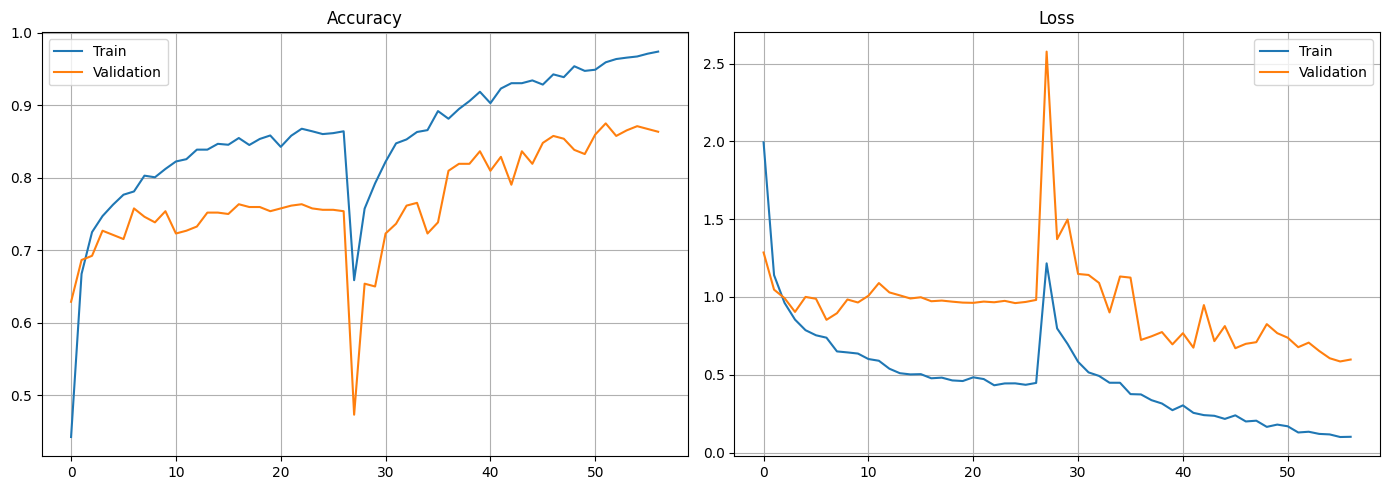


🎉 TRAINING COMPLETE!


In [ ]:
# ============================================
# COMPLETE TRANSFER LEARNING - RUN THIS
# ============================================

print("="*60)
print("TRANSFER LEARNING WITH MOBILENETV2")
print("="*60)

# Step 1: Load pre-trained MobileNetV2
print("\n1️⃣ Loading pre-trained model...")
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False
print(f"✓ MobileNetV2 loaded ({len(base_model.layers)} layers)")

# Step 2: Build model
print("\n2️⃣ Building model...")
num_classes = len(train_generator_fixed.class_indices)

model_transfer = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

print(f"✓ Model created for {num_classes} classes")

# Step 3: Compile
print("\n3️⃣ Compiling...")
model_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

# Step 4: Setup callbacks
print("\n4️⃣ Setting up callbacks...")
checkpoint_transfer = ModelCheckpoint(
    filepath=os.path.join(MODEL_SAVE_PATH, 'transfer_best.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_transfer = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_transfer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks_transfer = [checkpoint_transfer, early_stopping_transfer, reduce_lr_transfer]

# Step 5: Train Phase 1
print("\n" + "="*60)
print("PHASE 1: TRAINING (FROZEN BASE)")
print("="*60)

history_phase1 = model_transfer.fit(
    train_generator_fixed,
    epochs=30,
    validation_data=validation_generator_fixed,
    callbacks=callbacks_transfer,
    verbose=1
)

# Evaluate Phase 1
val_loss_p1, val_acc_p1 = model_transfer.evaluate(validation_generator_fixed, verbose=0)
print(f"\n✅ Phase 1 Complete!")
print(f"   Validation Accuracy: {val_acc_p1*100:.2f}%")
print(f"   Validation Loss: {val_loss_p1:.4f}")

# Step 6: Fine-tune (unfreeze top layers)
print("\n" + "="*60)
print("PHASE 2: FINE-TUNING")
print("="*60)

# Unfreeze top layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

print(f"✓ Unfrozen top layers")

# Recompile with lower LR
model_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Phase 2
checkpoint_finetune = ModelCheckpoint(
    filepath=os.path.join(MODEL_SAVE_PATH, 'finetuned_best.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks_finetune = [checkpoint_finetune, early_stopping_transfer, reduce_lr_transfer]

history_phase2 = model_transfer.fit(
    train_generator_fixed,
    epochs=30,
    validation_data=validation_generator_fixed,
    callbacks=callbacks_finetune,
    verbose=1
)

# Final evaluation
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

train_loss, train_acc = model_transfer.evaluate(train_generator_fixed, verbose=0)
val_loss, val_acc = model_transfer.evaluate(validation_generator_fixed, verbose=0)

print(f"\n📊 FINAL PERFORMANCE:")
print(f"   Training Accuracy: {train_acc*100:.2f}%")
print(f"   Validation Accuracy: {val_acc*100:.2f}%")
print(f"   Training Loss: {train_loss:.4f}")
print(f"   Validation Loss: {val_loss:.4f}")

# Save final model
model_transfer.save(os.path.join(MODEL_SAVE_PATH, 'chromabloom_final.h5'))
print(f"\n✓ Model saved!")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

combined_acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
combined_val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
combined_loss = history_phase1.history['loss'] + history_phase2.history['loss']
combined_val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

ax1.plot(combined_acc, label='Train')
ax1.plot(combined_val_acc, label='Validation')
ax1.set_title('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(combined_loss, label='Train')
ax2.plot(combined_val_loss, label='Validation')
ax2.set_title('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n🎉 TRAINING COMPLETE!")

DETAILED EVALUATION
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step


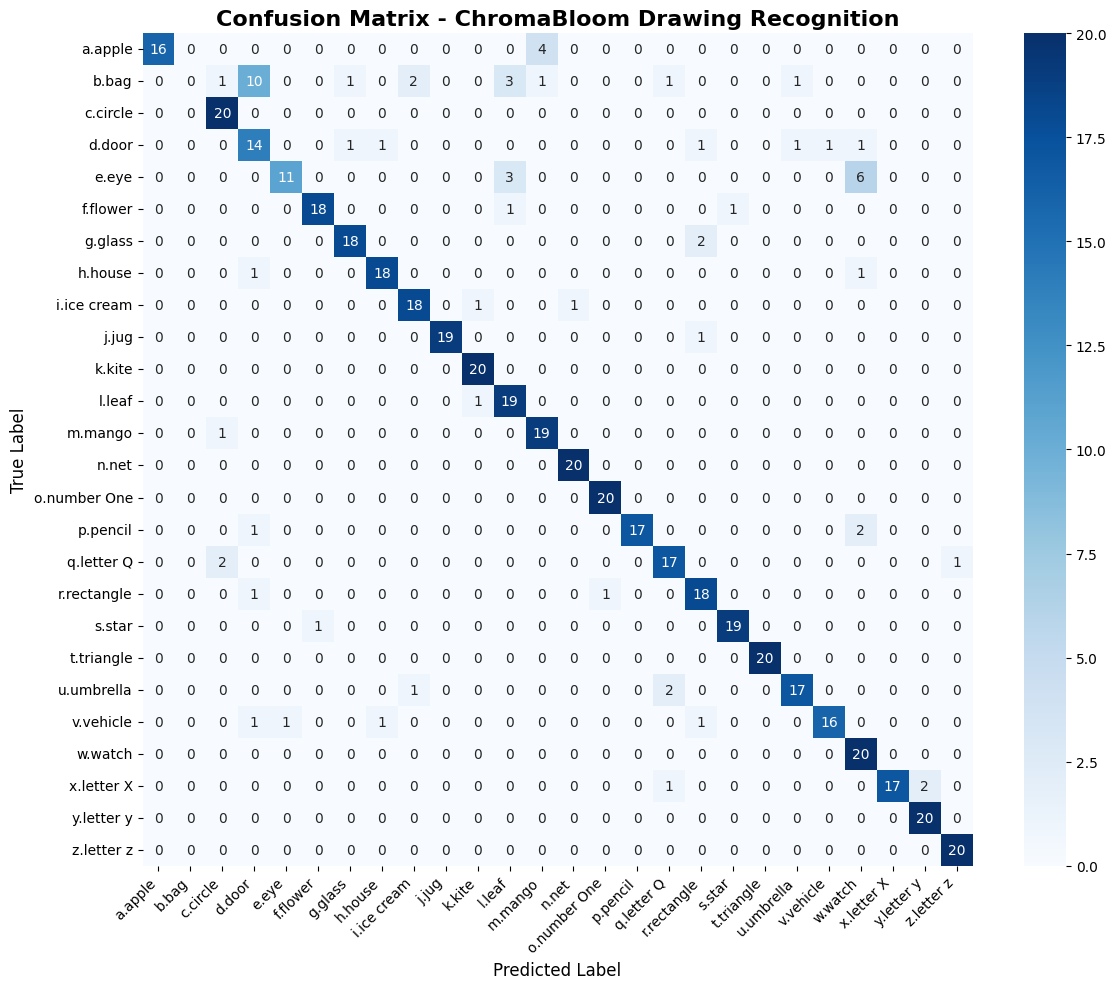


📋 Classification Report:
              precision    recall  f1-score   support

     a.apple       1.00      0.80      0.89        20
       b.bag       0.00      0.00      0.00        20
    c.circle       0.83      1.00      0.91        20
      d.door       0.50      0.70      0.58        20
       e.eye       0.92      0.55      0.69        20
    f.flower       0.95      0.90      0.92        20
     g.glass       0.90      0.90      0.90        20
     h.house       0.90      0.90      0.90        20
 i.ice cream       0.86      0.90      0.88        20
       j.jug       1.00      0.95      0.97        20
      k.kite       0.91      1.00      0.95        20
      l.leaf       0.73      0.95      0.83        20
     m.mango       0.79      0.95      0.86        20
       n.net       0.95      1.00      0.98        20
o.number One       0.95      1.00      0.98        20
    p.pencil       1.00      0.85      0.92        20
  q.letter Q       0.81      0.85      0.83        20
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluate per-class performance
print("="*60)
print("DETAILED EVALUATION")
print("="*60)

# Get predictions
validation_generator_fixed.reset()
y_pred = model_transfer.predict(validation_generator_fixed, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator_fixed.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(validation_generator_fixed.class_indices.keys())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, cbar=True)
plt.title('Confusion Matrix - ChromaBloom Drawing Recognition',
          fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print("="*60)
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# Save report
with open(os.path.join(MODEL_SAVE_PATH, 'classification_report.txt'), 'w') as f:
    f.write(report)

print(f"\n✓ Reports saved to {MODEL_SAVE_PATH}")

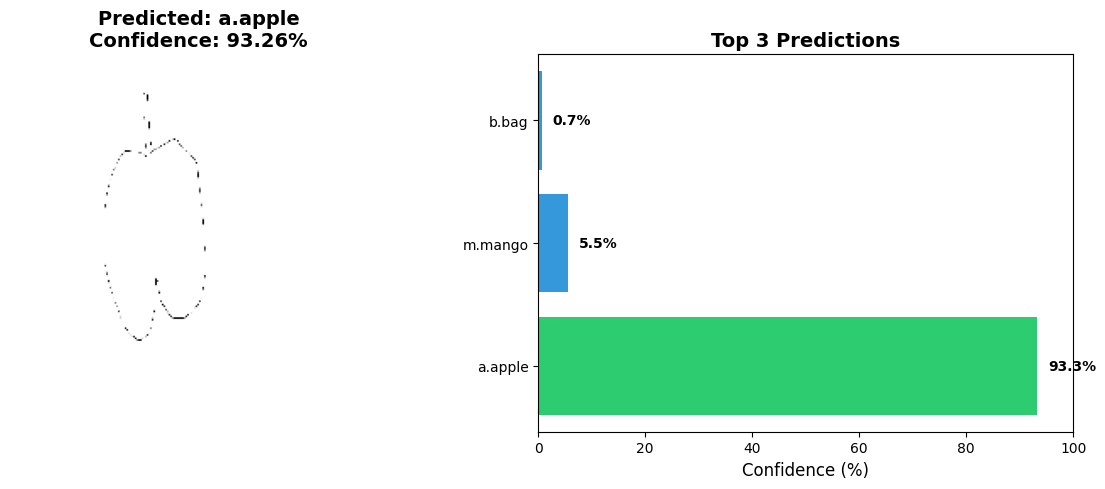


PREDICTION DETAILS
📁 Image: /content/drive/MyDrive/Dataset/Testing Data/a.apple/20.png
🎯 Predicted: a.apple
💯 Confidence: 93.26%

📊 Top 3 Predictions:
   1. a.apple: 93.26%
   2. m.mango: 5.54%
   3. b.bag: 0.74%


In [ ]:
# Define the prediction function
def predict_drawing(image_path, model, class_indices):
    """Predict drawing class for a single image"""

    # Reverse class indices
    class_names = {v: k for k, v in class_indices.items()}

    # Load and preprocess
    img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    # Get top 3
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]

    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Show image
    ax1.imshow(img)
    ax1.set_title(f'Predicted: {class_names[predicted_class_idx]}\nConfidence: {confidence:.2f}%',
                  fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Show top 3 predictions
    top_3_classes = [class_names[idx] for idx in top_3_idx]
    top_3_probs = [predictions[0][idx] * 100 for idx in top_3_idx]

    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(3)]
    ax2.barh(top_3_classes, top_3_probs, color=colors)
    ax2.set_xlabel('Confidence (%)', fontsize=12)
    ax2.set_title('Top 3 Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlim([0, 100])

    for i, v in enumerate(top_3_probs):
        ax2.text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, 'single_prediction.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*60)
    print("PREDICTION DETAILS")
    print("="*60)
    print(f"📁 Image: {image_path}")
    print(f"🎯 Predicted: {class_names[predicted_class_idx]}")
    print(f"💯 Confidence: {confidence:.2f}%")
    print(f"\n📊 Top 3 Predictions:")
    for i, (cls, prob) in enumerate(zip(top_3_classes, top_3_probs), 1):
        print(f"   {i}. {cls}: {prob:.2f}%")
    print("="*60)

    return class_names[predicted_class_idx], confidence

# Now test with your image
test_image = '/content/drive/MyDrive/Dataset/Testing Data/a.apple/20.png'

predicted_class, confidence = predict_drawing(
    test_image,
    model_transfer,
    train_generator_fixed.class_indices
)

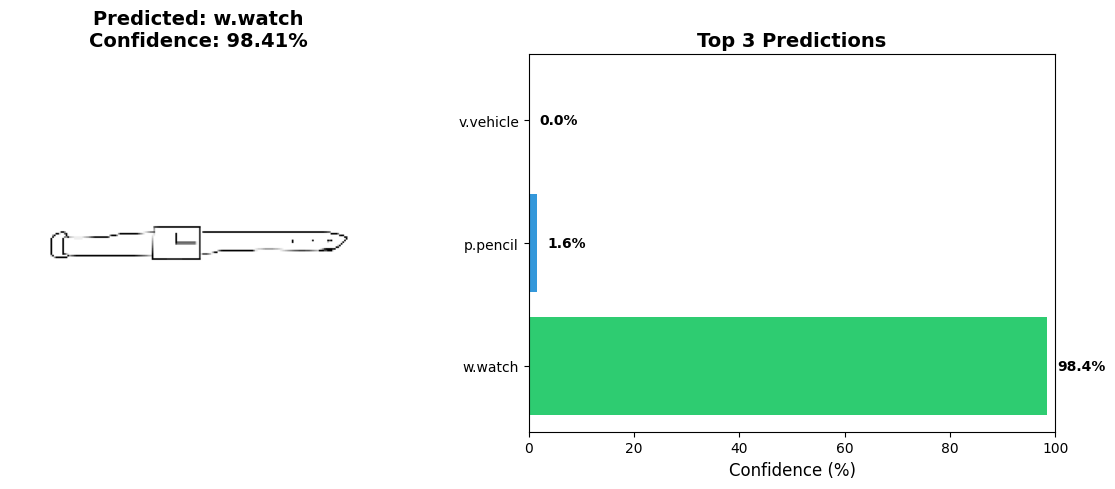


PREDICTION DETAILS
📁 Image: /content/drive/MyDrive/Dataset/Testing Data/w.watch/20.png
🎯 Predicted: w.watch
💯 Confidence: 98.41%

📊 Top 3 Predictions:
   1. w.watch: 98.41%
   2. p.pencil: 1.56%
   3. v.vehicle: 0.01%


In [ ]:
# Define the prediction function
def predict_drawing(image_path, model, class_indices):
    """Predict drawing class for a single image"""

    # Reverse class indices
    class_names = {v: k for k, v in class_indices.items()}

    # Load and preprocess
    img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    # Get top 3
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]

    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Show image
    ax1.imshow(img)
    ax1.set_title(f'Predicted: {class_names[predicted_class_idx]}\nConfidence: {confidence:.2f}%',
                  fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Show top 3 predictions
    top_3_classes = [class_names[idx] for idx in top_3_idx]
    top_3_probs = [predictions[0][idx] * 100 for idx in top_3_idx]

    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(3)]
    ax2.barh(top_3_classes, top_3_probs, color=colors)
    ax2.set_xlabel('Confidence (%)', fontsize=12)
    ax2.set_title('Top 3 Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlim([0, 100])

    for i, v in enumerate(top_3_probs):
        ax2.text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, 'single_prediction.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*60)
    print("PREDICTION DETAILS")
    print("="*60)
    print(f"📁 Image: {image_path}")
    print(f"🎯 Predicted: {class_names[predicted_class_idx]}")
    print(f"💯 Confidence: {confidence:.2f}%")
    print(f"\n📊 Top 3 Predictions:")
    for i, (cls, prob) in enumerate(zip(top_3_classes, top_3_probs), 1):
        print(f"   {i}. {cls}: {prob:.2f}%")
    print("="*60)

    return class_names[predicted_class_idx], confidence

# Now test with your image
test_image = '/content/drive/MyDrive/Dataset/Testing Data/w.watch/20.png'

predicted_class, confidence = predict_drawing(
    test_image,
    model_transfer,
    train_generator_fixed.class_indices
)

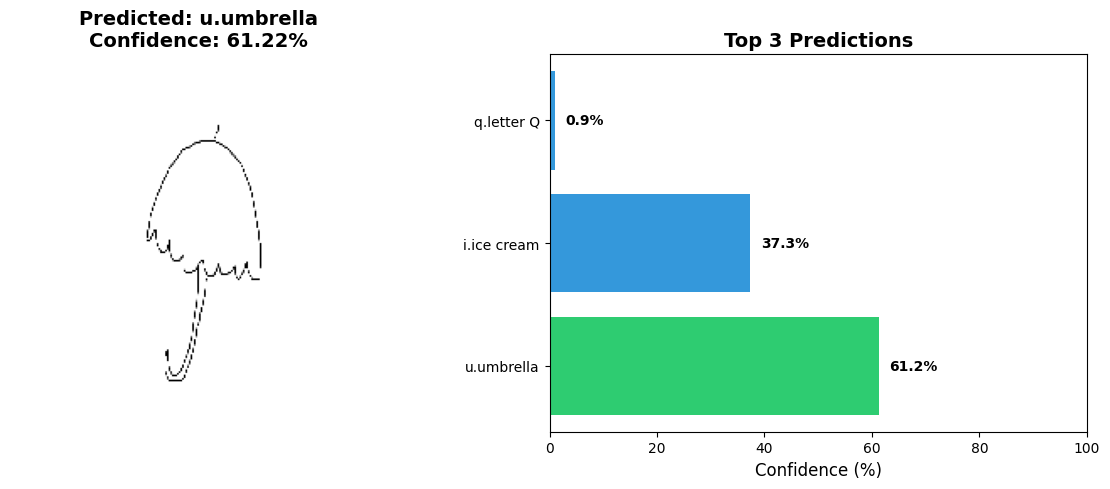


PREDICTION DETAILS
📁 Image: /content/drive/MyDrive/Dataset/Testing Data/u.umbrella/20.png
🎯 Predicted: u.umbrella
💯 Confidence: 61.22%

📊 Top 3 Predictions:
   1. u.umbrella: 61.22%
   2. i.ice cream: 37.34%
   3. q.letter Q: 0.93%


In [44]:
# Define the prediction function
def predict_drawing(image_path, model, class_indices):
    """Predict drawing class for a single image"""

    # Reverse class indices
    class_names = {v: k for k, v in class_indices.items()}

    # Load and preprocess
    img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    # Get top 3
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]

    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Show image
    ax1.imshow(img)
    ax1.set_title(f'Predicted: {class_names[predicted_class_idx]}\nConfidence: {confidence:.2f}%',
                  fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Show top 3 predictions
    top_3_classes = [class_names[idx] for idx in top_3_idx]
    top_3_probs = [predictions[0][idx] * 100 for idx in top_3_idx]

    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(3)]
    ax2.barh(top_3_classes, top_3_probs, color=colors)
    ax2.set_xlabel('Confidence (%)', fontsize=12)
    ax2.set_title('Top 3 Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlim([0, 100])

    for i, v in enumerate(top_3_probs):
        ax2.text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, 'single_prediction.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*60)
    print("PREDICTION DETAILS")
    print("="*60)
    print(f"📁 Image: {image_path}")
    print(f"🎯 Predicted: {class_names[predicted_class_idx]}")
    print(f"💯 Confidence: {confidence:.2f}%")
    print(f"\n📊 Top 3 Predictions:")
    for i, (cls, prob) in enumerate(zip(top_3_classes, top_3_probs), 1):
        print(f"   {i}. {cls}: {prob:.2f}%")
    print("="*60)

    return class_names[predicted_class_idx], confidence

# Now test with your image
test_image = '/content/drive/MyDrive/Dataset/Testing Data/u.umbrella/20.png'

predicted_class, confidence = predict_drawing(
    test_image,
    model_transfer,
    train_generator_fixed.class_indices
)

In [45]:
# Test all images from the 'apple' class
import os
from pathlib import Path

def test_class_performance(class_name, data_path):
    """Test all images from a specific class"""

    class_path = os.path.join(data_path, class_name)

    if not os.path.exists(class_path):
        print(f"❌ Class folder not found: {class_path}")
        return

    image_files = [f for f in os.listdir(class_path)
                   if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"\n{'='*60}")
    print(f"TESTING CLASS: {class_name}")
    print(f"{'='*60}")
    print(f"Total images: {len(image_files)}\n")

    correct = 0
    predictions = []

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)

        try:
            # Load and predict
            img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            pred = model_transfer.predict(img_array, verbose=0)
            pred_class_idx = np.argmax(pred[0])
            confidence = pred[0][pred_class_idx] * 100

            class_names = {v: k for k, v in train_generator_fixed.class_indices.items()}
            pred_class = class_names[pred_class_idx]

            is_correct = pred_class == class_name
            if is_correct:
                correct += 1

            symbol = '✓' if is_correct else '✗'
            predictions.append({
                'file': img_file,
                'predicted': pred_class,
                'confidence': confidence,
                'correct': is_correct
            })

            print(f"{symbol} {img_file:20s} -> {pred_class:15s} ({confidence:5.1f}%)")

        except Exception as e:
            print(f"❌ Error processing {img_file}: {e}")

    accuracy = (correct / len(image_files)) * 100

    print(f"\n{'='*60}")
    print(f"Class Accuracy: {correct}/{len(image_files)} ({accuracy:.1f}%)")
    print(f"{'='*60}")

    return predictions

# Test the apple class
apple_results = test_class_performance('a.apple', '/content/drive/MyDrive/Dataset/Testing Data')


TESTING CLASS: a.apple
Total images: 20

✓ 7.jpg                -> a.apple         ( 99.8%)
✓ 17.png               -> a.apple         ( 48.3%)
✗ 15.png               -> m.mango         ( 84.8%)
✓ 5.jpg                -> a.apple         ( 90.4%)
✓ 4.jpg                -> a.apple         ( 99.9%)
✓ 19.png               -> a.apple         ( 99.2%)
✓ 8.jpg                -> a.apple         (100.0%)
✗ 14.png               -> m.mango         ( 51.9%)
✗ 11.png               -> m.mango         ( 87.8%)
✓ 20.png               -> a.apple         ( 93.3%)
✓ 1.jpg                -> a.apple         ( 92.2%)
✓ 13.png               -> a.apple         ( 92.4%)
✓ 9.jpg                -> a.apple         (100.0%)
✓ 18.png               -> a.apple         ( 59.0%)
✓ 3.jpg                -> a.apple         ( 99.6%)
✗ 12.png               -> m.mango         ( 95.2%)
✓ 10.jpg               -> a.apple         ( 87.5%)
✓ 2.jpg                -> a.apple         (100.0%)
✓ 16.png               -> a.apple       